In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
# from pandas import DataFrame

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

from keras.models import load_model

from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Turn off warning
import warnings
warnings.filterwarnings('ignore')


This series takes 32 previous instances
Training size :  6025
Validation and Testing size :  1291


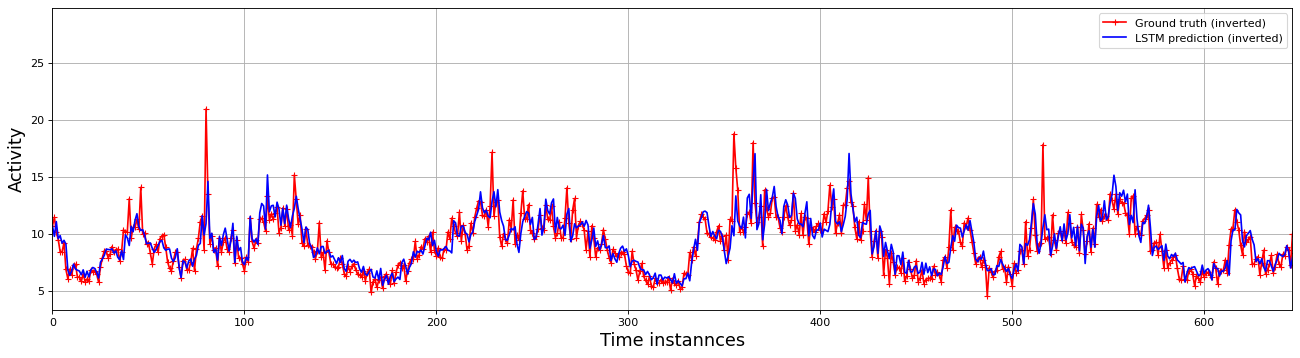

Mean percentage error is: 8.107039133850376.


In [2]:

def create_data(series, prev_instances = 4):

    '''
    series: This indicates the actual series
    prev_instances; This indicates how many previous timestamps does we need to train
    '''
    
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    Data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
        X_train_temp = X_train_temp.shift(1)
        Data = pd.concat([X_train_temp, Data], axis=1)
    Data.dropna(inplace = True)
    Data.reset_index(drop = True, inplace = True)
    # print(Data.head(10))

    X = Data.iloc[:, 0:-1].values 
    Y = Data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    Data.columns = [*Data.columns[:-1], 'Y']
    
    return Data, X, Y  


def main():
    
    df_G1 = pd.read_csv('Grid4500_61days.csv') 
    Internet_vals = df_G1.Internet.values.reshape(-1,1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(Internet_vals)

    prev_instances = 32;
    time_series = scaled_data;
    Data, X, Y = create_data(time_series, prev_instances = prev_instances)

    # # How many steps do we want to proceed in the time series
    n_steps = 1 

    # # How many features do we have in the time series
    n_features = prev_instances

    training_ratio = 0.7

    train_size = int(np.floor(len(Data)*training_ratio))
    val_size = int((len(Data) - train_size)/2)
    test_size = int((len(Data) - train_size)/2)

    x_train = X[:train_size]
    y_train = Y[:train_size]

    x_valid = X[train_size:-val_size]
    y_valid = Y[train_size:-val_size]

    x_test = X[train_size+val_size:]
    y_test = Y[train_size+val_size:]

    print('Training size : ', train_size)
    print('Validation and Testing size : ', val_size)    
    
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], n_steps, n_features))
    x_valid = x_valid.reshape((x_valid.shape[0], n_steps, n_features))
    x_test = x_test.reshape((x_test.shape[0], n_steps, n_features))

    model_LSTM = Sequential()
    model_LSTM.add(LSTM(100, activation = 'relu', input_shape=(n_steps, n_features)))
    model_LSTM.add(Dense(100, activation='relu'))
    model_LSTM.add(Dense(50, activation='relu'))
    model_LSTM.add(Dense(20, activation='relu'))
    model_LSTM.add(Dense(5, activation='relu'))
    model_LSTM.add(Dense(1))
    # model_LSTM.compile(loss='mae', optimizer = 'adax') #optimizer = "adamax", 'nadam', 'adam'
    model_LSTM.compile(loss='mae', optimizer = 'adamax')

    history_LSTM = model_LSTM.fit(x_train, y_train, epochs=400, batch_size=64, validation_data=(x_valid, y_valid), verbose=0, shuffle=False)    
    
    # model_LSTM = load_model("LSTM_model.h5")
    
    # Predicting the future traffic using .predict()
    y_pred_LSTM = model_LSTM.predict(np.asarray(x_test).astype('float32'))

    # Plotting results
    Inverse_y_test = y_test.reshape(-1,1)
    Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
    
    Inverse_y_pred_LSTM = y_pred_LSTM.reshape(-1,1)
    Inverse_y_pred_LSTM = scaler.inverse_transform(Inverse_y_pred_LSTM)

    figure(figsize=(20, 5), dpi=80)
    plt.plot(Inverse_y_test, "b-+", label='Ground truth (inverted)', color = "red")
    plt.plot(Inverse_y_pred_LSTM, "b-", label='LSTM prediction (inverted)', color = "blue")
    plt.legend()    
    plt.xlim(0, len(y_test)/2)

    plt.xlabel('Time instannces', fontsize=16)
    plt.ylabel('Activity', fontsize=16)
    plt.grid()
    plt.show()
        
    P_error = np.abs((Inverse_y_test.reshape(-1) - Inverse_y_pred_LSTM.reshape(-1))/Inverse_y_test.reshape(-1))*100 
    print(f'Mean percentage error is: {P_error.mean()}.')
    
    return model_LSTM, Inverse_y_test, Inverse_y_pred_LSTM
    
if __name__ == "__main__":
    model_, y_test, y_predict = main()    
    model_.save('LSTM_model_2.h5')  # creates a HDF5 file 'my_model.h5'
    
    Percent_error = np.abs((y_test.reshape(-1) - y_predict.reshape(-1))/y_test.reshape(-1))*100 
    
    dfx= pd.DataFrame({'y_test': y_test.reshape(-1), 
                   'y_predict': y_predict.reshape(-1),
                  'percentage_errr': Percent_error})
    
    dfx.to_csv('output.csv')
    with open('Mean_Percent_error.txt', 'w') as f:
        f.write(str(Percent_error.mean()))

In [1]:
Percent_error = np.abs((y_test.reshape(-1) - y_predict.reshape(-1))/y_test.reshape(-1))*100 
MSE = np.square(np.subtract(y_test.reshape(-1),y_predict.reshape(-1))).mean() 
RMSE = np.sqrt(MSE)
print(f"Root Mean Square Error: {RMSE}\n")
print(f"Mean Square Error: {MSE}\n")

df_err = pd.DataFrame({'MAPE': [Percent_error.mean()], 'Mean Square Error': [MSE], 'Root Mean Square Error': [RMSE]})
df_err.to_csv('Error_file_model2.csv')

df2= pd.DataFrame({'y_test': y_test.reshape(-1), 
                   'y_predict': y_predict.reshape(-1),
                  'percentage_errr': Percent_error})
df2.to_csv('output_model2.csv')

# with open('Mean_Percent_error.txt', 'w') as f:
#     f.write(str(Percent_error.mean()))

NameError: name 'np' is not defined

In [ ]:
#Declare the array containing the series you want to plot. 
#For example:
time_series_array = np.sin(np.linspace(-np.pi, np.pi, 400)) + np.random.rand((400))
n_steps           = 15 #number of rolling steps for the mean/std.

#Compute curves of interest:
time_series_df = pd.DataFrame(time_series_array)
smooth_path    = time_series_df.rolling(n_steps).mean()
path_deviation = 2 * time_series_df.rolling(n_steps).std()

under_line     = (smooth_path-path_deviation)[0]
over_line      = (smooth_path+path_deviation)[0]

#Plotting:
plt.plot(smooth_path, linewidth=2) #mean curve.
plt.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1) #std curves.